<a href="https://colab.research.google.com/github/AlnBnd/my-projects/blob/main/Images_Classification_with_Dense_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U Kaggler

In [ ]:
from google.colab import files
files.upload()

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d moltean/fruits

In [ ]:
!unzip /content/fruits.zip

In [ ]:
!pip install catalyst==20.08.1

In [ ]:
!pip install git+https://github.com/albumentations-team/albumentations.git

In [8]:
import numpy as np  
import pandas as pd 
import json
import os

In [9]:
from typing import List, Tuple, Callable

In [10]:
from pathlib import Path
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils import data

import catalyst
from catalyst import dl
from catalyst.dl import utils
from catalyst.utils import metrics, set_global_seed

In [11]:
ROOT = "/content/fruits-360"
ALL_IMAGES = list(Path(ROOT).glob("**/*.jpg"))
ALL_IMAGES = list(filter(lambda x: not x.name.startswith("."), ALL_IMAGES))
print("Number of images:", len(ALL_IMAGES))

Number of images: 90483


In [12]:
from catalyst.utils import imread
import matplotlib.pyplot as plt

def show_examples(images: List[Tuple[str, np.ndarray]]):
    _indexes = [(i, j) for i in range(2) for j in range(2)]
    
    f, ax = plt.subplots(2, 2, figsize=(8, 8))
    for (i, j), (title, img) in zip(_indexes, images):
        ax[i, j].imshow(img)
        ax[i, j].set_title(title)
    f.tight_layout()

def read_random_images(paths: List[Path]) -> List[Tuple[str, np.ndarray]]:
    data = np.random.choice(paths, size=4)
    result = []
    for d in data:
        title = f"{d.parent.name}: {d.name}"
        _image = imread(d)
        result.append((title, _image))
    
    return result

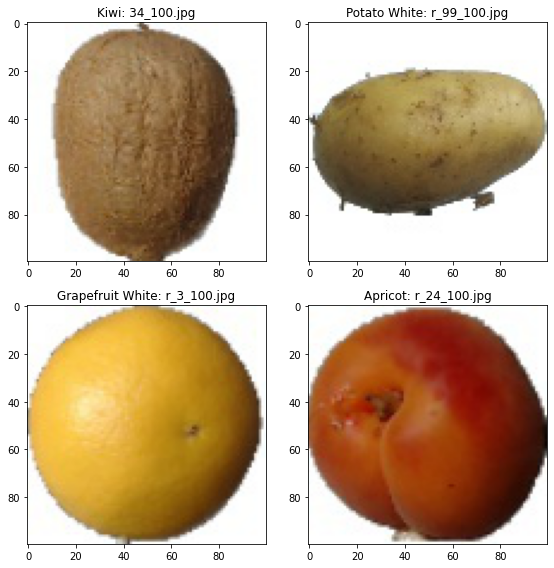

In [13]:
images = read_random_images(ALL_IMAGES)
show_examples(images)

In [14]:
from catalyst.utils import (
    create_dataset, create_dataframe, get_dataset_labeling, map_dataframe, split_dataframe_train_test
)

In [15]:
dataset = create_dataset(dirs=f"/content/fruits-360/Training/*", extension="*.jpg")
df = create_dataframe(dataset, columns=["class", "filepath"])

tag_to_label = get_dataset_labeling(df, "class")
class_names = [
    name for name, id_ in sorted(tag_to_label.items(), key=lambda x: x[1])
]

df_with_labels = map_dataframe(
    df, 
    tag_column="class", 
    class_column="label", 
    tag2class=tag_to_label, 
    verbose=False
)
df_with_labels.head()

,class,filepath,label
0,Apple Braeburn,/content/fruits-360/Training/Apple Braeburn/0_...,0
1,Apple Braeburn,/content/fruits-360/Training/Apple Braeburn/10...,0
2,Apple Braeburn,/content/fruits-360/Training/Apple Braeburn/10...,0
3,Apple Braeburn,/content/fruits-360/Training/Apple Braeburn/10...,0
4,Apple Braeburn,/content/fruits-360/Training/Apple Braeburn/10...,0


In [16]:
df_with_labels['class'].value_counts()

Grape Blue       984
Plum 3           900
Tomato 3         738
Peach 2          738
Cherry 2         738
                ... 
Cucumber Ripe    392
Tomato Maroon    367
Pear Kaiser      300
Mangostan        300
Ginger Root      297
Name: class, Length: 131, dtype: int64

In [17]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [18]:
train_data, valid_data = split_dataframe_train_test(
    df_with_labels, test_size=0.3, random_state=42
)
train_data, valid_data = (
    train_data.to_dict("records"),
    valid_data.to_dict("records"),
)

In [19]:
len(train_data), len(valid_data)

(47384, 20308)

In [20]:
set_global_seed(42)

In [21]:
from catalyst.data.cv.reader import ImageReader
from catalyst.data import ScalarReader, ReaderCompose

num_classes = len(tag_to_label)

open_fn = ReaderCompose(
    [
        ImageReader(
            input_key="filepath", output_key="features", rootpath="train"
        ),
        ScalarReader(
            input_key="label",
            output_key="targets",
            default_value=-1,
            dtype=np.int64,
        ),
        ScalarReader(
            input_key="label",
            output_key="targets_one_hot",
            default_value=-1,
            dtype=np.int64,
            one_hot_classes=num_classes,
        ),
    ]
)


In [22]:
import albumentations as albu
from albumentations.pytorch import ToTensor

IMAGE_SIZE = 224

train_transform = albu.Compose([
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.Resize(IMAGE_SIZE, IMAGE_SIZE),
    albu.PadIfNeeded(IMAGE_SIZE, IMAGE_SIZE, border_mode=0),
    albu.RandomRotate90(),
    albu.Normalize(),
    ToTensor()
])

valid_transform = albu.Compose([
    albu.HorizontalFlip(p=0.5),
    albu.Resize(IMAGE_SIZE, IMAGE_SIZE),
    albu.PadIfNeeded(IMAGE_SIZE, IMAGE_SIZE, border_mode=0),
    albu.Normalize(),
    ToTensor()
])

In [23]:
from catalyst.data import Augmentor

train_data_transform = Augmentor(
    dict_key="features", augment_fn=lambda x: train_transform(image=x)["image"]
)

valid_data_transform = Augmentor(
    dict_key="features", augment_fn=lambda x: valid_transform(image=x)["image"]
)

In [24]:
# from catalyst import utils

batch_size = 64  
num_workers = 4

train_loader = utils.get_loader(
    train_data,
    open_fn=open_fn,
    dict_transform=train_data_transform,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    sampler=None,
    drop_last=True,
)

valid_loader = utils.get_loader(
    valid_data,
    open_fn=open_fn,
    dict_transform=valid_data_transform,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False, 
    sampler=None,
    drop_last=True,
)

loaders = {
    "train": train_loader,
    "valid": valid_loader
}

In [25]:
import dense_net
import imp
imp.reload(dense_net)


in_channels=3
growth_rate=32
num_convs_in_blocks=(6, 12, 24, 16)
in_features=64
num_classes=131

model = dense_net.DenseNet(in_channels, growth_rate, num_convs_in_blocks, in_features, num_classes).to(device)

In [26]:
from catalyst.dl import SupervisedRunner

class ClassificationRunner(SupervisedRunner):
    def predict_batch(self, batch):
        prediction = {
            "filepath": batch["filepath"],
            "log_probs": self.model(batch[self.input_key].to(self.device))
        }
        return prediction

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20)
epochs = 15

In [28]:
runner = ClassificationRunner(input_key="features", input_target_key="targets")
runner.train(
    model=model,
    optimizer=optimizer,
    # scheduler=scheduler, 
    criterion=criterion,
    loaders=loaders,
    logdir=Path("logs") / datetime.now().strftime("%Y%m%d-%H%M%S"),
    num_epochs=epochs,
    verbose=True,
    main_metric="accuracy01",
    minimize_metric=False,
    load_best_on_end=True,
    callbacks={
        "optimizer": dl.OptimizerCallback(
            metric_key="loss", accumulation_steps=1, grad_clip_params=None,
        ),
        "criterion": dl.CriterionCallback(
            input_key="targets", output_key="logits", prefix="loss",
        ),
        "accuracy": dl.AccuracyCallback(),
    },
)

1/25 * Epoch (train): 100% 740/740 [01:45<00:00,  7.00it/s, accuracy01=0.953, loss=0.213]
1/25 * Epoch (valid): 100% 317/317 [00:25<00:00, 12.28it/s, accuracy01=0.906, loss=0.308]
[2021-01-04 08:42:57,017] 
1/25 * Epoch 1 (_base): lr=0.0003 | momentum=0.9000
1/25 * Epoch 1 (train): accuracy01=0.8625 | loss=0.5963
1/25 * Epoch 1 (valid): accuracy01=0.9292 | loss=0.2386
2/25 * Epoch (train): 100% 740/740 [01:46<00:00,  6.97it/s, accuracy01=0.984, loss=0.031]
2/25 * Epoch (valid): 100% 317/317 [00:25<00:00, 12.42it/s, accuracy01=0.953, loss=0.170]
[2021-01-04 08:45:08,876] 
2/25 * Epoch 2 (_base): lr=0.0003 | momentum=0.9000
2/25 * Epoch 2 (train): accuracy01=0.9795 | loss=0.0792
2/25 * Epoch 2 (valid): accuracy01=0.9521 | loss=0.1455
3/25 * Epoch (train): 100% 740/740 [01:46<00:00,  6.97it/s, accuracy01=0.984, loss=0.053]
3/25 * Epoch (valid): 100% 317/317 [00:26<00:00, 12.05it/s, accuracy01=0.906, loss=0.217]
[2021-01-04 08:47:21,520] 
3/25 * Epoch 3 (_base): lr=0.0003 | momentum=0.9000

In [ ]:
from PIL import Image
from tqdm.notebook import tqdm

submission = {"Id": [], "Category": []}
model.eval()

test_dataset = create_dataset(dirs=f"/content/fruits-360/Test/", extension="*.jpg")
test_data = list({"filepath": filepath} for filepath in test_dataset["test"])

test_open_fn = ReaderCompose(
    [
        ImageReader(
            input_key="filepath", output_key="features", rootpath=""
        ),
        ScalarReader(
            input_key="filepath",
            output_key="filepath",
            default_value="",
            dtype=str,
        ),
    ]
)

test_loader = utils.get_loader(
    test_data,
    open_fn=test_open_fn,
    dict_transform=valid_data_transform,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    sampler=None,
    drop_last=False,
)